<a href="https://colab.research.google.com/github/margareta10/202055202004-margareta/blob/master/jenisparfum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d margaretawursok/jenis-parfum
!mkdir jenis-parfum
!unzip /content/jenis-parfum.zip -d /content/jenis-parfum

 82% 5.00M/6.13M [00:00<00:00, 49.1MB/s]
100% 6.13M/6.13M [00:00<00:00, 57.4MB/s]
mkdir: cannot create directory ‘jenis-parfum’: File exists
Archive:  /content/jenis-parfum.zip
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (1).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (10).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (100).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (11).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (12).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (13).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (14).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (15).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (16).jpg  
  inflating: /content/jenis-parfum/Jenis Parfumm/parfum gas/kaleng (17).jpg  
  inflating: /content/jenis-parfum/Jenis Pa

In [8]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [14]:
dataset_path = Path(r'/content/jenis-parfum')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [15]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/jenis-parfum/Jenis Parfumm/parfum pla...,parfum plastik
1,/content/jenis-parfum/Jenis Parfumm/parfum pla...,parfum plastik
2,/content/jenis-parfum/Jenis Parfumm/parfum pla...,parfum plastik
3,/content/jenis-parfum/Jenis Parfumm/parfum pla...,parfum plastik
4,/content/jenis-parfum/Jenis Parfumm/parfum pla...,parfum plastik


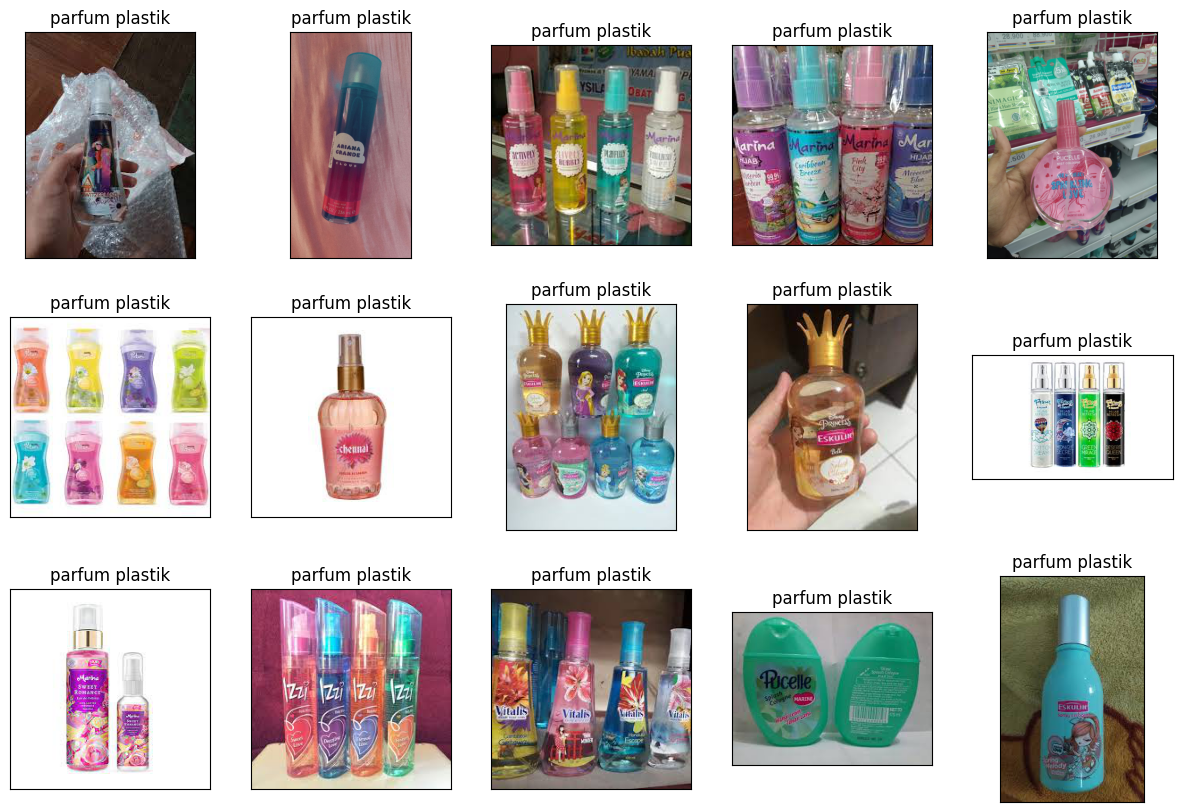

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [17]:
df.label.value_counts()

parfum plastik    100
parfum gas        100
parfum kaca       100
Name: label, dtype: int64

In [18]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

parfum plastik    100
parfum gas        100
parfum kaca       100
Name: label, dtype: int64

In [19]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [20]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [22]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [23]:
input_shape = (200, 200, 3)

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [25]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
6/6 [==============================] - 38s 7s/step - loss: 1.1545 - accuracy: 0.3333 - val_loss: 1.0962 - val_accuracy: 0.3810
Epoch 2/100
6/6 [==============================] - 27s 4s/step - loss: 1.0969 - accuracy: 0.3214 - val_loss: 1.0884 - val_accuracy: 0.3571
Epoch 3/100
6/6 [==============================] - 27s 4s/step - loss: 1.0946 - accuracy: 0.3274 - val_loss: 1.0800 - val_accuracy: 0.3810
Epoch 4/100
6/6 [==============================] - 27s 5s/step - loss: 1.0852 - accuracy: 0.3810 - val_loss: 1.0494 - val_accuracy: 0.5476
Epoch 5/100
6/6 [==============================] - 26s 4s/step - loss: 1.0486 - accuracy: 0.5238 - val_loss: 1.0023 - val_accuracy: 0.5476
Epoch 6/100
6/6 [==============================] - 29s 5s/step - loss: 0.9969 - accuracy: 0.5000 - val_loss: 0.9370 - val_accuracy: 0.5476
Epoch 7/100
6/6 [==============================] - 26s 4s/step - loss: 1.1940 - accuracy: 0.3929 - val_loss: 1.0700 - val_accuracy: 0.3810
Epoch 8/100
6/6 [==========

In [26]:
model.save('model-1.h5')

In [27]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

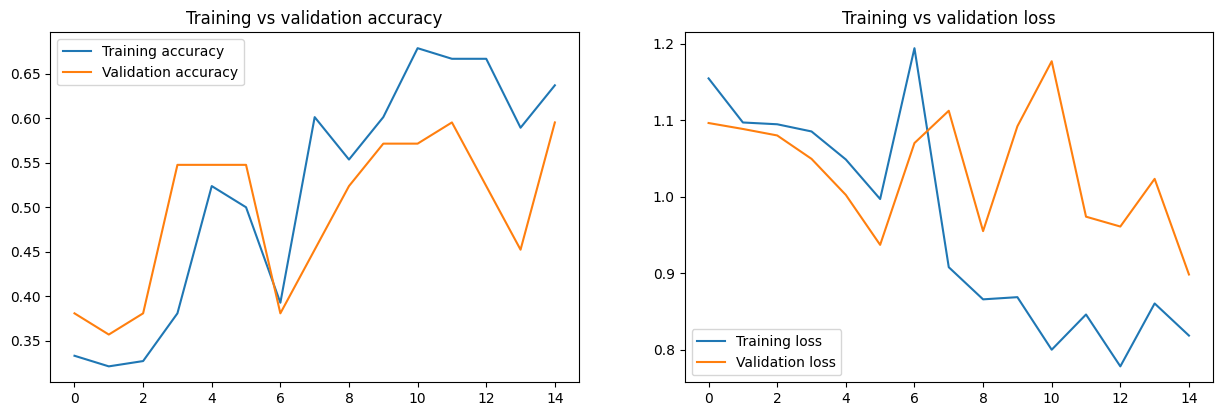

In [28]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [29]:
pred = model.predict(test)

3/3 [==============================] - 4s 1s/step


In [30]:
pred = np.argmax(pred, axis=1)

In [31]:
labels = train.class_indices

In [32]:
labels

{'parfum gas': 0, 'parfum kaca': 1, 'parfum plastik': 2}

In [33]:
labels = dict((v,k) for k, v in labels.items())

In [34]:
labels

{0: 'parfum gas', 1: 'parfum kaca', 2: 'parfum plastik'}

In [35]:
y_pred = [labels[k] for k in pred]

In [36]:
print(classification_report(x_test.label, y_pred))

                precision    recall  f1-score   support

    parfum gas       0.71      0.45      0.56        33
   parfum kaca       0.58      0.58      0.58        24
parfum plastik       0.62      0.85      0.72        33

      accuracy                           0.63        90
     macro avg       0.64      0.63      0.62        90
  weighted avg       0.65      0.63      0.62        90



In [37]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 5s 2s/step - loss: 0.8545 - accuracy: 0.6333
